## Pizza-Radar-for-Football-Player-Analysis

If previously we compared players from the same team to evaluate who is the best in specific aspects, we will now use the pizza radar to compare one player with the rest of the players in the same position and competition, in order to evaluate how much better/worse they are, or in what they are similar to the others.

This project demonstrates how to create a comparative pizza radar to evaluate a football player against others in the same position and competition. The analysis uses player performance data from the Premier League, processed in Python.

#### Objectives

1. Import and clean player performance data.
2. Filter players by position for meaningful comparisons.
3. Convert key stats into percentiles.
4. Generate a pizza radar visualization to compare a target player with the rest of the group.

#### Dataset

The dataset used in this project includes Premier League player statistics and it is from FBREF
Values are filtered to include only defenders, with **Trent Alexander-Arnold as the target player.**

#### Tools & Libraries

1. Python
2. Pandas
3. Numpy
4. Matplotlib
5. mplsoccer

#### Output

- A comparative pizza radar displaying the player’s percentile rank across selected performance metrics relative to other defenders in the league.

#### Purpose

- This visualization helps identify strengths, weaknesses, and performance profile differences between players in the same role, providing support for tactical and scouting analysis.




In [1]:
!pip install statsbombpy --quiet
!pip install mplsoccer --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 3.4 MB/s eta 0:00:00


In [2]:
# import the necessary libraries

import seaborn as sns
from statsbombpy import sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch, PyPizza, add_image, FontManager
import math

from scipy import stats

In [3]:
df = pd.read_csv("/kaggle/input/futbol-analysis-pizza-radius-graph/pizza_tutorial.csv")

# Correct the players name since the format now is 'Patrick van Aanholt\Patrick-van-Aanholt'
df['Player'] = df['Player'].str.split('\\', expand=True)[0]
df.head()

,Rk,Player,Nation,Pos,Squad,Age,Born,90s,Tackles,Tkls Won,...,Dribbled Past,Successful Pressures,Def 3rd Press,Mid 3rd Press,Att 3rd Press,Blocks,Interceptions,Tkl+Int,Clearances,Errors
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,30-259,1990,19.7,1.62,0.96,...,1.37,3.45,6.55,2.84,1.02,1.57,1.73,3.35,2.03,0.05
1,2,Tammy Abraham,eng ENG,FW,Chelsea,23-225,1997,11.6,0.69,0.34,...,0.43,3.28,1.12,6.12,6.72,0.78,0.17,0.86,1.47,0.00
2,3,Che Adams,sco SCO,FW,Southampton,24-306,1996,28.1,1.03,0.57,...,0.57,4.70,1.71,5.41,7.12,0.89,0.36,1.39,0.57,0.04
3,4,Tosin Adarabioyo,eng ENG,DF,Fulham,23-233,1997,29.8,1.28,0.77,...,0.54,1.78,3.66,1.64,0.23,1.17,1.68,2.95,7.38,0.03
4,5,Adrián,es ESP,GK,Liverpool,34-132,1987,3.0,0.00,0.00,...,0.00,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.33


We want to analyze only defenders, because as you will see later, we want to compare Trent Alexander-Arnold with the rest of the players who play as defenders in the Premier League.

In [4]:
# only defender with more than 15 games
# Better to use `loc` since in this case we can use that data frame without copying it

defenders_df = df.loc[(df['Pos'] == 'DF') & (df['90s'] > 15)]
defenders_df.head()

,Rk,Player,Nation,Pos,Squad,Age,Born,90s,Tackles,Tkls Won,...,Dribbled Past,Successful Pressures,Def 3rd Press,Mid 3rd Press,Att 3rd Press,Blocks,Interceptions,Tkl+Int,Clearances,Errors
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,30-259,1990,19.7,1.62,0.96,...,1.37,3.45,6.55,2.84,1.02,1.57,1.73,3.35,2.03,0.05
3,4,Tosin Adarabioyo,eng ENG,DF,Fulham,23-233,1997,29.8,1.28,0.77,...,0.54,1.78,3.66,1.64,0.23,1.17,1.68,2.95,7.38,0.03
6,7,Ola Aina,ng NGA,DF,Fulham,24-219,1996,28.9,1.63,0.87,...,0.80,2.11,4.74,3.11,0.76,1.56,1.76,3.39,4.19,0.00
8,9,Semi Ajayi,ng NGA,DF,West Brom,27-187,1993,27.9,2.04,1.47,...,0.54,4.48,7.46,3.33,0.57,1.90,1.25,3.30,4.70,0.07
12,13,Toby Alderweireld,be BEL,DF,Tottenham,32-074,1989,21.9,1.55,0.73,...,0.50,2.97,5.16,3.06,0.14,1.96,0.46,2.01,6.80,0.00


### We get the data with the player we want

We use .values to check all the defenders included in the dataset in addition to the player we are interested in:

In [5]:
# We will check which are the players that we have
defenders_df.Player.values 

# or what it the saeme...
# defenders_df['Player'].unique()

array(['Patrick van Aanholt', 'Tosin Adarabioyo', 'Ola Aina',
       'Semi Ajayi', 'Toby Alderweireld', 'Trent Alexander-Arnold',
       'Ezgjan Alioski', 'Joachim Andersen', 'Serge Aurier',
       'Luke Ayling', 'César Azpilicueta', 'George Baldock',
       'Kyle Bartley', 'Jan Bednarek', 'Héctor Bellerín', 'Ryan Bertrand',
       'Willy Boly', 'Dan Burn', 'Gary Cahill', 'João Cancelo',
       'Matty Cash', 'Timothy Castagne', 'Ben Chilwell',
       'Andreas Christensen', 'Ciaran Clark', 'Conor Coady',
       'Séamus Coleman', 'Liam Cooper', 'Vladimír Coufal',
       'Aaron Cresswell', 'Craig Dawson', 'Rúben Dias', 'Eric Dier',
       'Lucas Digne', 'Issa Diop', 'Gabriel Dos Santos', 'Lewis Dunk',
       'John Egan', 'Jonny Evans', 'Federico Fernández', 'Wesley Fofana',
       'Darnell Furlong', 'Ben Godfrey', 'Rob Holding', 'Mason Holgate',
       'Reece James', 'James Justin', 'Michael Keane', 'Ezri Konsa',
       'Cheikhou Kouyaté', 'Jamaal Lascelles', 'Jamal Lewis',
       'Victor

In [6]:
player_remove = defenders_df.loc[defenders_df['Player'] == 'Trent Alexander-Arnold'].reset_index()
player_remove

,index,Rk,Player,Nation,Pos,Squad,Age,Born,90s,Tackles,...,Dribbled Past,Successful Pressures,Def 3rd Press,Mid 3rd Press,Att 3rd Press,Blocks,Interceptions,Tkl+Int,Clearances,Errors
0,14,15,Trent Alexander-Arnold,eng ENG,DF,Liverpool,22-220,1998,30.7,1.76,...,0.75,3.52,3.62,3.45,2.51,1.34,1.34,3.09,2.12,0.03


In [7]:
trent_player = defenders_df.loc[defenders_df['Player'] == 'Trent Alexander-Arnold'].reset_index()
trent_player = list(trent_player.loc[0])
trent_player

[14,
 15,
 'Trent Alexander-Arnold',
 'eng ENG',
 'DF',
 'Liverpool',
 '22-220',
 1998,
 30.7,
 1.76,
 1.11,
 1.01,
 0.75,
 3.52,
 3.62,
 3.45,
 2.51,
 1.34,
 1.34,
 3.09,
 2.12,
 0.03]

## Cleaning and processing our data...
### We will need to delete de first 9 rows of this list since we need only number to plot

In [8]:
trent_player = trent_player[9:]
trent_player

[1.76, 1.11, 1.01, 0.75, 3.52, 3.62, 3.45, 2.51, 1.34, 1.34, 3.09, 2.12, 0.03]

### We delete the columns we dont need

To calculate our plot, we need those columns where the values are numbers, and that's because we need to compare number between numbers.
We need to delete all the columns where the data is not numbers...

In [9]:
drop_columns = [
'Rk',
'Nation',
'Pos',
'Squad',
'90s',
'Age',
'Born',
'Player',
]

In [10]:
defenders_df = defenders_df.drop(drop_columns, axis=1).reset_index()
# defenders_df

### To make sure that thoose columns dont exist... we can use this command


In [11]:
print('Rk' in defenders_df)
print('Nation' in defenders_df)
print('Pos' in defenders_df)
print('Born' in defenders_df)
print('Player' in defenders_df)
print('Age' in defenders_df)
print('Squad' in defenders_df)

False
False
False
False
False
False
False


### We have to make sure that each of our columns would be an unique data to plot, so we have to split and control the data from each column


In [12]:
columns = list(defenders_df.columns)

# By this moment we kept the "index" column which we dont need. We will get rid of it. There are few ways to delete it... this ways are:

columns = columns[1:]
# columns.pop(0) # indicated by index

columns

['Tackles',
 'Tkls Won',
 'Tkls vs Dribbles',
 'Dribbled Past',
 'Successful Pressures',
 'Def 3rd Press',
 'Mid 3rd Press',
 'Att 3rd Press',
 'Blocks',
 'Interceptions',
 'Tkl+Int',
 'Clearances',
 'Errors']

### Calculate the stadistics with scipy

In [13]:
values = []

for column in range(len(columns)):
    value = math.floor(stats.percentileofscore(defenders_df[columns[column]], trent_player[column]))
    values.append(value)


# Calculate the percentil

for number, index in enumerate(values):
    if index == 100:
        values[number] == 99
    

### Plot The Radar Pizza

In [14]:
baker  = PyPizza(
    columns, 
    straight_line_color="#000000",
    straight_line_lw=1,
    last_circle_lw=1,
    other_circle_lw=1,
    other_circle_ls="-."
)

#### Using the following code, our pizza radar will display Trent Alexander-Arnold compared with other Premier League defenders. 

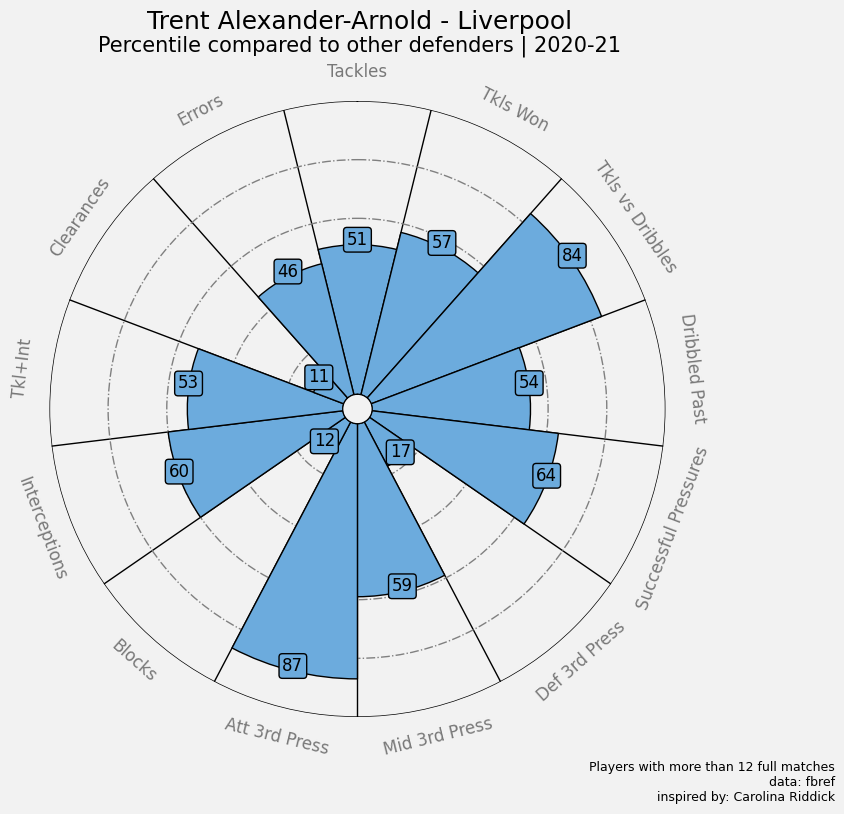

In [15]:
# pizza radar formatted according to the extracted data

fig, ax = baker.make_pizza(
    values,
    figsize=(10, 8),
    param_location=110,
    kwargs_slices=dict(
        facecolor="#6CABDD", 
        edgecolor="#000000",
        zorder=2, 
        linewidth=1
    ),
    
    kwargs_params=dict(
        color="#000000", 
        fontsize=12,
        va="center", 
        alpha=.5
    ),
    kwargs_values=dict(
        color="#000000", 
        fontsize=12,
        zorder=3,
        bbox=dict(
            edgecolor="#000000", 
            facecolor="#6CABDD",
            boxstyle="round,pad=0.2", 
            lw=1
        )
    )
)

# Radar title
fig.text(
    0.515, 0.97, 
    "Trent Alexander-Arnold - Liverpool", 
    size=18,
    ha="center", 
    color="#000000"
)

# Radar subtitle
fig.text(
    0.515, 0.942,
    "Percentile compared to other defenders | 2020-21",
    size=15,
    ha="center", 
    color="#000000"
)

# Add credits
notes = "Players with more than 12 full matches"
CREDIT_1 = "data: fbref"
CREDIT_2 = "inspired by: Carolina Riddick"

fig.text(
    0.99, 0.005, f"{notes}\n{CREDIT_1}\n{CREDIT_2}", size=9,
    color="#000000",
    ha="right"
)

plt.savefig("pizza.png", 
            dpi=500, 
            bbox_inches="tight")
